# Sensitivity Analysis

**Author**: Medha Agarwal

**Last Modified**: Oct 17, 2024


In [1]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                            get_figures_dir,
                            get_matched_data_path)

from src.utils.plot import(multi_label_predictions)

from src.utils.data import (setup_data_objects,
                            setup_multilabel_dataloaders,
                            get_exp_filter_profiles,
                            adjust_behavior_and_durations)

from src.utils.conformal import validate

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             VECTRONICS_METADATA_PATH,
                             AWD_VECTRONICS_PATHS,
                             id_mapping)

from src.data_prep.data_prep_utils import combined_annotations

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 35
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)

LabelEncoder()

In [6]:
acc_data = pd.read_csv(get_matched_data_path())
acc_data = adjust_behavior_and_durations(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS)

duration_percentiles = [20, 30, 40, 50, 60, 70, 80]
durations = [np.percentile(acc_data['duration'].values, d) for d in duration_percentiles]

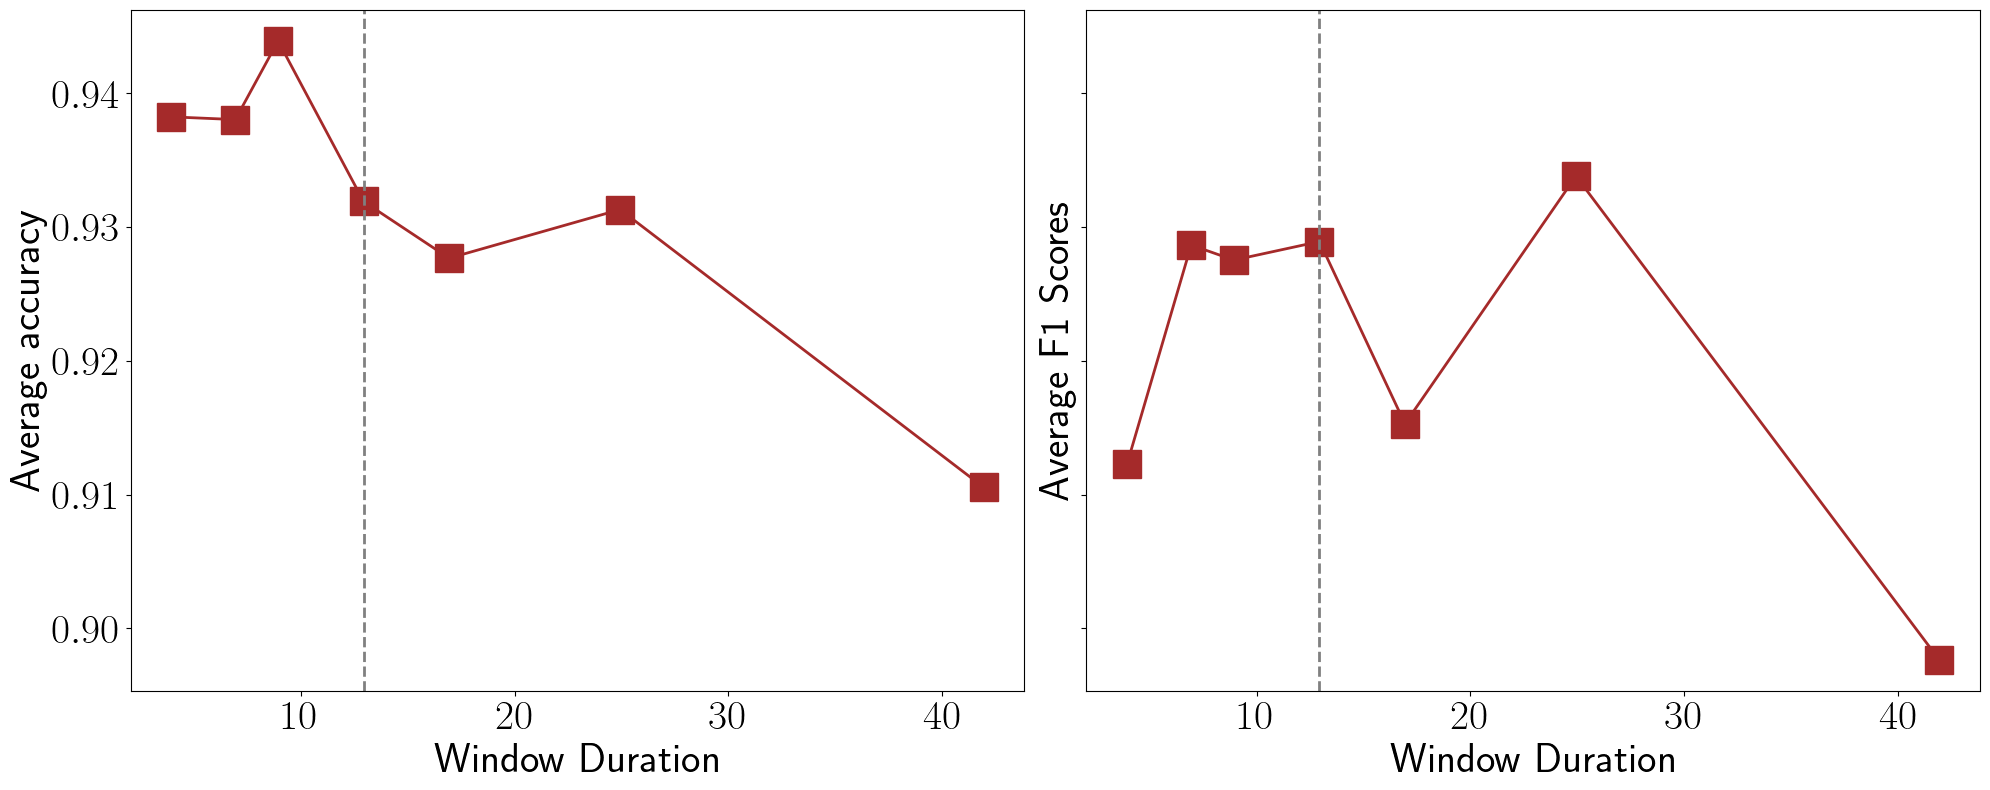

In [10]:
accuracies, f1_scores = np.zeros(len(duration_percentiles)), np.zeros(len(duration_percentiles))

for i,d in enumerate(duration_percentiles):
    dir = get_results_path('no_split', 5, 32, 5, 0.9, d)
    accuracies[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True)
    f1_scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

fig, axs = plt.subplots(1,2, figsize=(20,8), sharey=True)

axs[0].plot(durations, accuracies, markersize=20, marker='s', color='brown')
axs[0].set_ylabel('Average accuracy')
axs[0].set_xlabel('Window Duration')
axs[0].axvline(x = durations[3], linestyle='--', color='grey')

axs[1].plot(durations, f1_scores, markersize=20, marker='s', color='brown')
axs[1].set_ylabel('Average F1 Scores')
axs[1].set_xlabel('Window Duration')
axs[1].axvline(x = durations[3], linestyle='--', color='grey')

plt.tight_layout()
plt.show()